# Final Transformer Notebook – Air Pollution Forecasting
**MSML 612 – Group Project**  
Labeled cells for easy troubleshooting. This notebook:
- Implements a tuned Informer (Transformer) end‑to‑end (final model).
- Adds rolling evaluation across the entire test horizon.
- Logs inference time and runs a small **hyper‑parameter sweep**  

**Data assumption:** `pollution_2000_2023.csv` 

## (0) Setup – versions (run once per environment)

In [ ]:
# Setup for Windows / RTX 4060 Ti 

import sys, platform
print("Kernel interpreter:", sys.executable)
print("Python version :", platform.python_version())

%pip install -U pip setuptools wheel

# Torch 2.6.0 + CUDA 12.6  (pairs with torchvision 0.21.0)
%pip install torch==2.6.0 torchvision==0.21.0 --index-url https://download.pytorch.org/whl/cu126

%pip install "pytorch-lightning==2.5.3" "pytorch-forecasting==1.4.0" "neuralforecast==3.0.2" \
             "optuna>=3.5" "pandas>=2.2" "numpy>=1.26" "scikit-learn>=1.4" "matplotlib>=3.8" "seaborn>=0.13"

# --- sanity check (catches wrong kernel / CPU torch, etc.) ---
import importlib, torch, pytorch_lightning as pl, torch.optim.lr_scheduler as lrs
nf = importlib.import_module("neuralforecast")
pf = importlib.import_module("pytorch_forecasting")

print({
    "torch": torch.__version__,
    "torch_cuda": getattr(torch.version, "cuda", None),
    "cuda_available": torch.cuda.is_available(),
    "gpu": torch.cuda.get_device_name(0) if torch.cuda.is_available() else None,
    "has_LRScheduler": hasattr(lrs, "LRScheduler"),
    "lightning": pl.__version__,
    "neuralforecast": nf.__version__,
    "pytorch_forecasting": pf.__version__,
})

# If cuda_available=False or versions look wrong:
#   Kernel -> Restart, then re-run this cell.


Kernel interpreter: c:\Users\Rohan\AppData\Local\Programs\Python\Python310\python.exe
Python version   : 3.10.0
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


c:\Users\Rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-22 15:27:51,803	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-08-22 15:27:52,111	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


{'torch': '2.6.0+cu126', 'torch_cuda': '12.6', 'cuda_available': True, 'gpu': 'NVIDIA GeForce RTX 4060 Ti', 'has_LRScheduler': True, 'lightning': '2.5.3', 'neuralforecast': '3.0.2', 'pytorch_forecasting': '1.4.0'}


## (1) Imports, config, reproducibility

In [ ]:
# (1) Imports, config, reproducibility — Torch 2.x / Lightning 2.x / NF 3.x

import os, json, math, time, warnings, random, sys
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pytorch_lightning as pl
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# NeuralForecast (Informer)
from neuralforecast import NeuralForecast
from neuralforecast.models import Informer as NFInformer
from neuralforecast.losses.pytorch import MSE

# PyTorch-Forecasting (TFT baseline)
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

# --- Reproducibility & device setup ---
warnings.filterwarnings("ignore")
pl.seed_everything(42, workers=True)

# Apple silicon / modern GPUs benefit from this in PyTorch 2.x
torch.set_float32_matmul_precision("high")

DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(exist_ok=True)

@dataclass
class CFG:
    RAW_FILE: str = "pollution_2000_2023.csv" 
    INPUT_WINDOW: int = 60
    PRED_WINDOW: int = 3
    TRAIN_END: str = "2016-12-31"
    VAL_END: str   = "2020-12-31"
    # Informer hyperparams
    HIDDEN_SIZE: int = 128
    N_HEAD: int = 4
    FACTOR: int = 10
    DROPOUT: float = 0.1
    LR: float = 1e-3
    MAX_STEPS: int = 5000
    BATCH_SIZE: int = 64
    # Rolling evaluation
    ROLL_STEP_DAYS: int = 7

CFG = CFG()

# --- quick sanity print to  catch kernel/env mixups ---
print({
    "python": sys.executable,
    "device": DEVICE,
    "torch": torch.__version__,
    "lightning": pl.__version__,
    "neuralforecast": __import__("neuralforecast").__version__,
    "pytorch_forecasting": __import__("pytorch_forecasting").__version__,
})


Seed set to 42


{'python': 'c:\\Users\\Rohan\\AppData\\Local\\Programs\\Python\\Python310\\python.exe', 'device': 'cuda', 'torch': '2.6.0+cu126', 'lightning': '2.5.3', 'neuralforecast': '3.0.2', 'pytorch_forecasting': '1.4.0'}


## (2) Utility helpers

In [ ]:
# Utility helpers (metrics, plotting setup, dirs)
print(torch.__version__, "CUDA:", torch.version.cuda, "GPU OK:", torch.cuda.is_available())

def ensure_dirs():
    (RESULTS_DIR / "figs").mkdir(exist_ok=True, parents=True)
    (RESULTS_DIR / "logs" / "informer").mkdir(exist_ok=True, parents=True)
ensure_dirs()

def rmse(y_true, y_pred):
    return float(math.sqrt(mean_squared_error(y_true, y_pred)))

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return float(100.0 * np.mean(np.abs(y_pred - y_true) / denom))

def summarize_dict(d: Dict) -> str:
    return json.dumps(d, indent=2)

# Harmonizing units for reporting (convert ppm->ppb except NO2 already in ppb)
PPB_SCALE = {"O3": 1000.0, "CO": 1000.0, "SO2": 1000.0, "NO2": 1.0}
def to_ppb(arr, pollutant):
    return np.asarray(arr) * PPB_SCALE[pollutant]

plt.rcParams["figure.figsize"] = (9.5, 4)
plt.rcParams["axes.grid"] = True
sns.set_context("talk")


2.6.0+cu126 CUDA: 12.6 GPU OK: True


## (3) Load raw CSV and standardize columns/units

In [ ]:
# Load raw CSV and standardize columns/units
def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False)

    # Normalize column names
    df.columns = (
        pd.Series(df.columns)
        .str.strip().str.lower().str.replace(r"[^a-z0-9]+", "_", regex=True)
        .str.replace(r"_+", "_", regex=True).str.strip("_")
        .to_list()
    )

    # Date column
    date_col = "date" if "date" in df.columns else None
    if date_col is None:
        for c in ["ds", "timestamp", "date_local"]:
            if c in df.columns:
                date_col = c; break
    if date_col is None:
        raise ValueError("Could not find a date column.")
    df["date"] = pd.to_datetime(df[date_col])

    # City/State
    rename_map = {}
    if "city" not in df.columns:
        for c in ["local_site_name", "site_name"]:
            if c in df.columns: rename_map[c] = "city"
    if "state" not in df.columns:
        for c in ["state_name", "statecode", "state_code"]:
            if c in df.columns: rename_map[c] = "state"
    df = df.rename(columns=rename_map)

    # Pollutants (accept a few variants)
    def find_any(names):
        for n in names:
            if n in df.columns: return n
        return None
    o3_col  = find_any(["o3_mean", "o3", "o3_1st_max_value", "ozone"])
    no2_col = find_any(["no2_mean", "no2"])
    so2_col = find_any(["so2_mean", "so2"])
    co_col  = find_any(["co_mean",  "co"])
    keep_cols = ["date", "city", "state"]
    pol_map = {}
    if o3_col:  pol_map[o3_col]  = "o3"
    if no2_col: pol_map[no2_col] = "no2"
    if so2_col: pol_map[so2_col] = "so2"
    if co_col:  pol_map[co_col]  = "co"
    if not pol_map:
        raise ValueError("Expected pollutant mean columns (o3/no2/so2/co).")

    df_small = df[keep_cols + list(pol_map.keys())].copy()
    for src, tgt in pol_map.items():
        df_small = df_small.rename(columns={src: tgt})

    # numeric cast and drop NaNs
    for c in ["o3","no2","so2","co"]:
        if c in df_small.columns:
            df_small[c] = pd.to_numeric(df_small[c], errors="coerce")
    df_small = df_small.dropna(subset=[c for c in ["o3","no2","so2","co"] if c in df_small.columns])

    return df_small

RAW_FILE = CFG.RAW_FILE if Path(CFG.RAW_FILE).exists() else "cleaned_pollution_data.csv"
df_raw = load_csv(RAW_FILE)
print(f"Loaded: {RAW_FILE} | rows={len(df_raw):,}")
display(df_raw.head())


Loaded: pollution_2000_2023.csv | rows=665,414


,date,city,state,o3,no2,so2,co
0,2000-01-01,Phoenix,Arizona,0.019765,19.041667,3.000000,0.878947
1,2000-01-02,Phoenix,Arizona,0.015882,22.958333,1.958333,1.066667
2,2000-01-03,Phoenix,Arizona,0.009353,38.125000,5.250000,1.762500
3,2000-01-04,Phoenix,Arizona,0.015882,40.260870,7.083333,1.829167
4,2000-01-05,Phoenix,Arizona,0.007353,48.450000,8.708333,2.700000


## (4) Feature engineering (calendar + lags)

In [5]:
# (4) Feature engineering (calendar + lags)
def add_calendar_and_lags(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["month"] = out["date"].dt.month.astype(int)
    out["dayofweek"] = out["date"].dt.dayofweek.astype(int)
    out["isweekend"] = out["dayofweek"].isin([5,6]).astype(int)
    out["iswedthur"] = out["dayofweek"].isin([2,3]).astype(int)
    # Lags per city (helps short-term autocorrelation)
    out = out.sort_values(["city", "date"]).copy()
    for pol in [c for c in ["o3","no2","so2","co"] if c in out.columns]:
        out[f"{pol}_lag1"] = out.groupby(["city"])[pol].shift(1)
    pol_cols = [c for c in ["o3","no2","so2","co"] if c in out.columns]
    out["pollution_avg"] = out[pol_cols].mean(axis=1)
    out = out.dropna().reset_index(drop=True)
    return out

df_feat = add_calendar_and_lags(df_raw)
print("Feature columns added. Preview:")
display(df_feat.head(10))

Feature columns added. Preview:


,date,city,state,o3,no2,so2,co,month,dayofweek,isweekend,iswedthur,o3_lag1,no2_lag1,so2_lag1,co_lag1,pollution_avg
0,2011-01-02,Albuquerque,New Mexico,0.018824,11.504762,0.162500,0.275000,1,6,1,0,0.032471,9.180952,0.054167,0.200000,2.990271
1,2011-01-03,Albuquerque,New Mexico,0.008412,23.342857,0.720833,0.479167,1,0,0,0,0.018824,11.504762,0.162500,0.275000,6.137817
2,2011-01-04,Albuquerque,New Mexico,0.027471,23.245455,0.887500,0.604167,1,1,0,0,0.008412,23.342857,0.720833,0.479167,6.191148
3,2011-01-05,Albuquerque,New Mexico,0.033294,12.637500,0.445833,0.204167,1,2,0,1,0.027471,23.245455,0.887500,0.604167,3.330198
4,2011-01-06,Albuquerque,New Mexico,0.030500,11.800000,0.285714,0.200000,1,3,0,1,0.033294,12.637500,0.445833,0.204167,3.079054
5,2011-01-07,Albuquerque,New Mexico,0.026353,18.716667,0.325000,0.261905,1,4,0,0,0.030500,11.800000,0.285714,0.200000,4.832481
6,2011-01-08,Albuquerque,New Mexico,0.019235,21.662500,0.575000,0.391667,1,5,1,0,0.026353,18.716667,0.325000,0.261905,5.662100
7,2011-01-09,Albuquerque,New Mexico,0.028000,22.312500,0.479167,0.370833,1,6,1,0,0.019235,21.662500,0.575000,0.391667,5.797625
8,2011-01-10,Albuquerque,New Mexico,0.034941,9.958333,0.120833,0.208333,1,0,0,0,0.028000,22.312500,0.479167,0.370833,2.580610
9,2011-01-11,Albuquerque,New Mexico,0.016353,19.241667,0.325000,0.275000,1,1,0,0,0.034941,9.958333,0.120833,0.208333,4.964505


## (5) Long format for Informer – `unique_id, ds, y`

In [ ]:
# Long format for Informer – unique_id, ds, y
def to_long_for_nf(df: pd.DataFrame) -> pd.DataFrame:
    pol_cols = [c for c in ["o3","no2","so2","co"] if c in df.columns]
    id_cols = ["date","city","state"]
    long_df = df[id_cols + pol_cols].melt(
        id_vars=id_cols, value_vars=pol_cols, var_name="pollutant", value_name="y"
    ).dropna()
    long_df["unique_id"] = (
        long_df["city"].str.replace(r"[^A-Za-z0-9]+", "", regex=True)
        + "_" + long_df["state"].str.replace(r"[^A-Za-z0-9]+", "", regex=True)
        + "_" + long_df["pollutant"]
    ).str.lower()
    long_df = long_df.rename(columns={"date":"ds"})[["unique_id","ds","y"]].sort_values(["unique_id","ds"])
    return long_df

df_nf = to_long_for_nf(df_feat)
print(f"Long rows: {len(df_nf):,} | series={df_nf['unique_id'].nunique():,}")
display(df_nf.head())


Long rows: 2,661,056 | series=680


,unique_id,ds,y
1995792,albuquerque_newmexico_co,2011-01-02,0.275000
1995793,albuquerque_newmexico_co,2011-01-03,0.479167
1995794,albuquerque_newmexico_co,2011-01-04,0.604167
1995795,albuquerque_newmexico_co,2011-01-05,0.204167
1995796,albuquerque_newmexico_co,2011-01-06,0.200000


## (6) Chronological train/val/test split + coverage tables

In [ ]:
# Chronological train/val/test split + coverage
TRAIN_END = pd.Timestamp(CFG.TRAIN_END)
VAL_END   = pd.Timestamp(CFG.VAL_END)

train_mask = df_nf["ds"] <= TRAIN_END
val_mask   = (df_nf["ds"] > TRAIN_END) & (df_nf["ds"] <= VAL_END)
test_mask  = df_nf["ds"] > VAL_END

train_df = df_nf[train_mask].copy()
val_df   = df_nf[val_mask].copy()
test_df  = df_nf[test_mask].copy()

def counts_table():
    split_counts = pd.Series({
        "raw_rows": len(df_raw),
        "feat_rows": len(df_feat),
        "long_rows": len(df_nf),
        "train_rows": len(train_df),
        "val_rows": len(val_df),
        "test_rows": len(test_df),
    }).to_frame("count")
    series_counts = pd.Series({
        "train_unique_series": train_df["unique_id"].nunique(),
        "val_unique_series":   val_df["unique_id"].nunique(),
        "test_unique_series":  test_df["unique_id"].nunique(),
    }).to_frame("n_series")
    return split_counts, series_counts

split_counts, series_counts = counts_table()
print("=== Split row counts ==="); display(split_counts)
print("=== Unique series per split ==="); display(series_counts)
print("Date ranges:",
      train_df["ds"].min().date(), "→", train_df["ds"].max().date(), "(train) |",
      val_df["ds"].min().date() if len(val_df) else None, "→", val_df["ds"].max().date() if len(val_df) else None, "(val) |",
      test_df["ds"].min().date() if len(test_df) else None, "→", test_df["ds"].max().date() if len(test_df) else None, "(test)")


=== Split row counts ===


,count
raw_rows,665414
feat_rows,665264
long_rows,2661056
train_rows,1858752
val_rows,497660
test_rows,304644


=== Unique series per split ===


,n_series
train_unique_series,660
val_unique_series,352
test_unique_series,328


Date ranges: 2000-01-01 → 2016-12-31 (train) | 2017-01-01 → 2020-12-31 (val) | 2021-01-01 → 2023-09-30 (test)


## (7) Train Informer (final tuned transformer)

In [ ]:
# Train Informer
from pytorch_lightning.loggers import CSVLogger

# Rebuild the splits after a reset
if "df_nf" not in globals():
    raise RuntimeError("df_nf missing. Run cells (3)–(6) first.")

df_train_val = pd.concat([train_df, val_df], ignore_index=True)

csv_logger = CSVLogger(save_dir=str(RESULTS_DIR / "logs"), name="informer")

informer = NFInformer(
    h = CFG.PRED_WINDOW,
    input_size = CFG.INPUT_WINDOW,
    hidden_size = CFG.HIDDEN_SIZE,
    n_head = CFG.N_HEAD,
    factor = CFG.FACTOR,
    dropout = CFG.DROPOUT,
    learning_rate = CFG.LR,
    loss = MSE(),
    scaler_type = "standard",
    batch_size = CFG.BATCH_SIZE,
    max_steps = CFG.MAX_STEPS,
    val_check_steps = 100,
    # everything below is forwarded to pl.Trainer via BaseModel
    trainer_kwargs = dict(
        logger=csv_logger,
        enable_progress_bar=True,
        accelerator="auto",
        devices=1,
        gradient_clip_val=0.5,
        log_every_n_steps=50,
        # num_sanity_val_steps=0,   # uncomment if you want to skip sanity check
    ),
)

# patch for NF builds 
if hasattr(informer, "trainer_kwargs"):
    tk = informer.trainer_kwargs
    if isinstance(tk, dict) and "trainer_kwargs" in tk and isinstance(tk["trainer_kwargs"], dict):
        informer.trainer_kwargs = tk["trainer_kwargs"]
    if isinstance(informer.trainer_kwargs, dict) and "trainer_kwargs" in informer.trainer_kwargs:
        informer.trainer_kwargs.pop("trainer_kwargs", None)

nf = NeuralForecast(models=[informer], freq="D")

t0 = time.perf_counter()
nf.fit(df=df_train_val, val_size=365)  # 1-year rolling validation inside training
train_secs = time.perf_counter() - t0
print(f"Informer trained in {train_secs:.2f} s")

MODEL_NAME = "Informer"
ART_DIR = RESULTS_DIR  


Seed set to 1
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 199 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
341 K     Trainable params
0         Non-trainable params
341 K     Total params
1.368     Total est

Epoch 999: 100%|██████████| 11/11 [00:15<00:00,  0.69it/s, v_num=0, train_loss_step=1.740, train_loss_epoch=1.150, valid_loss=5.580]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 11/11 [00:15<00:00,  0.69it/s, v_num=0, train_loss_step=1.740, train_loss_epoch=1.150, valid_loss=5.580]
✅ Informer trained in 3236.85 s


## (8) 

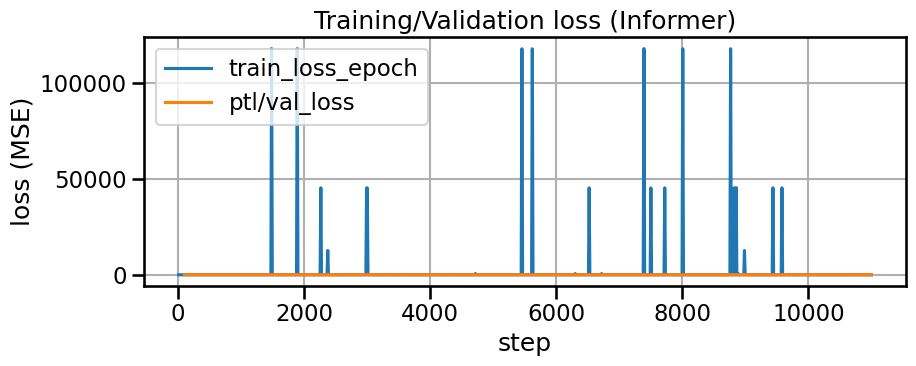

In [ ]:
# Plot training/validation loss from CSV logger
def _latest_metrics_csv(log_root: Path) -> Path | None:
    root = log_root / "informer"
    if not root.exists():
        return None
    versions = sorted(root.glob("version_*"), key=lambda p: p.stat().st_mtime, reverse=True)
    if not versions:
        return None
    path = versions[0] / "metrics.csv"
    return path if path.exists() else None

metrics_path = _latest_metrics_csv(RESULTS_DIR / "logs")
if metrics_path is None:
    print("No metrics.csv found")
else:
    metrics = pd.read_csv(metrics_path)
    cand_train = [c for c in metrics.columns if "train" in c and "loss" in c]
    cand_val = [c for c in metrics.columns if ("val" in c or "valid" in c) and "loss" in c]
    step_col = "step" if "step" in metrics.columns else None

    plt.figure(figsize=(9.5,4))
    if cand_train:
        m = metrics.dropna(subset=[cand_train[0]])
        plt.plot(m[step_col] if step_col else np.arange(len(m)), m[cand_train[0]], label=cand_train[0])
    if cand_val:
        m = metrics.dropna(subset=[cand_val[0]])
        plt.plot(m[step_col] if step_col else np.arange(len(m)), m[cand_val[0]], label=cand_val[0])
    plt.title("Training/Validation loss (Informer)")
    plt.xlabel("step" if step_col else "index")
    plt.ylabel("loss (MSE)")
    plt.legend()
    plt.tight_layout()
    plt.show()


## (9) Rolling evaluation across the full test horizon (weekly anchors)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.31it/s]
📊 Immediate-horizon metrics (Informer):


,model,pollutant,RMSE_ppm,MAE_ppm,R2,SMAPE_%,MSE_ppb2,N
0,Informer,CO,0.107,0.069,0.518,11.659,11406.785,254
1,Informer,NO2,4.194,3.249,0.579,17.959,17.593,254
2,Informer,O3,0.007,0.005,0.137,13.979,43.710,254
3,Informer,SO2,0.240,0.179,0.653,35.432,57534.193,254


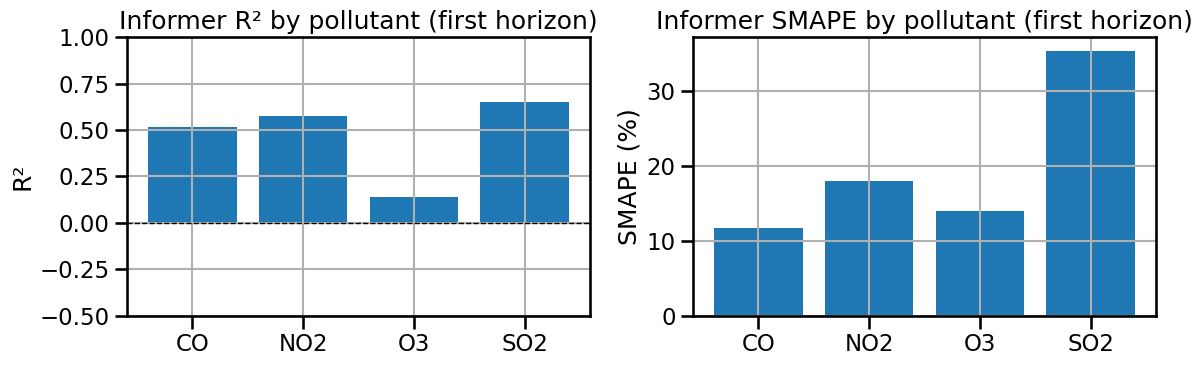

In [ ]:
# Immediate-horizon evaluation (first test window: 2021-01-01..2021-01-03)
MODEL_NAME = "Informer"
OUT_DIR = RESULTS_DIR  # keep artifact paths the same

# Forecast next H steps (NeuralForecast returns wide: ['unique_id','ds','<model-name>'])
fcst = nf.predict()
pred_col = [c for c in fcst.columns if c not in ("unique_id", "ds")][0]

# Truth slice that exactly matches the forecast horizon
h_start, h_end = fcst["ds"].min(), fcst["ds"].max()
truth_slice = test_df[(test_df["ds"] >= h_start) & (test_df["ds"] <= h_end)].copy()

# Align truth / preds
eval_df = (
    truth_slice.merge(fcst, on=["unique_id", "ds"], how="left")
               .rename(columns={pred_col: "y_pred"})
)
# Recover pollutant tag from unique_id
eval_df["pollutant"] = (
    eval_df["unique_id"].str.extract(r"_(o3|no2|so2|co)$")[0].str.upper()
)

# Compute metrics per pollutant (R^2 on native units, SMAPE/MSE in ppb)
rows = []
metrics_immediate = {}
for pol, grp in eval_df.groupby("pollutant"):
    y = grp["y"].to_numpy()
    yhat = grp["y_pred"].to_numpy()
    scale = PPB_SCALE[pol]
    y_ppb, yhat_ppb = y * scale, yhat * scale

    row = {
        "RMSE_ppm": rmse(y, yhat),
        "MAE_ppm": mean_absolute_error(y, yhat),
        "R2": r2_score(y, yhat), # unit-invariant
        "SMAPE_%": smape(y_ppb, yhat_ppb), # report in %
        "MSE_ppb2": float(np.mean((y_ppb - yhat_ppb) ** 2)),
        "N": int(len(grp)),
    }
    metrics_immediate[pol] = row
    rows.append({"model": MODEL_NAME, "pollutant": pol, **row})

immediate_tbl = pd.DataFrame(rows).sort_values("pollutant").reset_index(drop=True)

print("Immediate-horizon metrics (Informer):")
display(immediate_tbl.round(3))
#persisting artifcacts
(OUT_DIR / "metrics_immediate_informer.json").write_text(json.dumps(metrics_immediate, indent=2))
immediate_tbl.to_csv(OUT_DIR / "metrics_immediate_informer.csv", index=False)

# bars
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].bar(immediate_tbl["pollutant"], immediate_tbl["R2"])
ax[0].set_title("Informer R^2 by pollutant (first horizon)")
ax[0].set_ylim(-0.5, 1.0)
ax[0].set_ylabel("R^2")
ax[0].axhline(0.0, color="k", linestyle="--", linewidth=1)

ax[1].bar(immediate_tbl["pollutant"], immediate_tbl["SMAPE_%"])
ax[1].set_title("Informer SMAPE by pollutant (first horizon)")
ax[1].set_ylabel("SMAPE (%)")

plt.tight_layout()
plt.show()


## (10) Inference timing (per‑series, 3‑step horizon)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.75it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.39it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.95it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 41.97it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 39.85it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.15it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 42.07it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 41.82it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 39.93it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 41.90it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.30it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.10it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.61it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 41.02it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.81it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 41.65it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.05it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 51.97it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.99it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.51it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.47it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 52.67it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.27it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 52.23it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 50.90it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.75it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.60it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.81it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 53.91it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 50.92it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 53.13it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 44.95it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 50.56it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.58it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.08it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.59it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 44.36it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.42it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.60it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.00it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.08it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.61it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.59it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.03it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.11it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.95it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.85it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.64it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 50.13it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.66it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.87it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.60it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.21it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 40.71it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.10it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.17it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.83it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.64it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 42.25it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.95it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 41.82it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.87it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.69it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.92it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.28it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.23it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 42.88it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.33it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.74it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.68it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.30it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 42.97it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.81it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 44.04it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 50.22it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 53.98it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 44.83it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 51.67it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 50.48it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 51.84it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 42.89it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.09it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.87it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.89it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.03it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.17it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.45it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.24it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.35it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.83it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.41it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.70it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.48it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.05it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.31it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.98it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.53it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.07it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 37.77it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 44.98it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.44it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 44.80it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 39.44it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 44.95it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.98it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 42.22it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.56it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.08it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.74it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 44.88it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.08it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 39.61it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.03it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 43.38it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.87it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 44.01it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 40.08it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 47.22it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 42.30it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 39.46it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 39.52it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.24it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 51.15it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 50.54it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 51.77it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 51.63it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 40.72it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 51.39it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 52.26it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.91it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 50.44it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.27it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 52.88it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 49.54it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 40.96it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 45.97it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 44.45it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 50.52it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.22it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 46.60it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 48.60it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 41.92it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 50.26it/s]
Anchors: 143 | time=181.70s


,pollutant,R2,SMAPE_%,MSE_ppb2,N
0,CO,0.502,17.450,10496.471,32150
1,NO2,0.259,20.582,20.398,32150
2,O3,0.185,10.610,57.068,32150
3,SO2,0.593,31.314,83795.158,32150


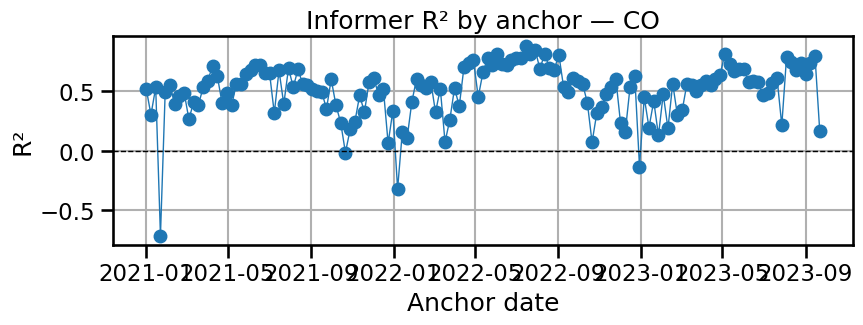

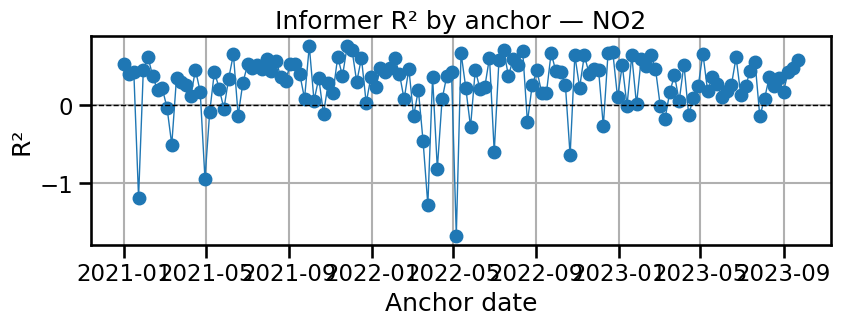

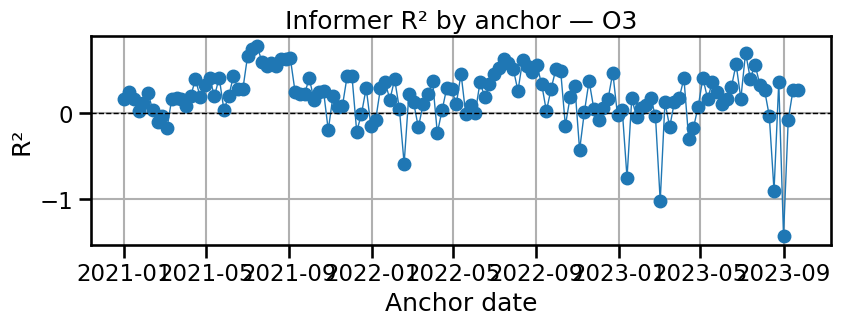

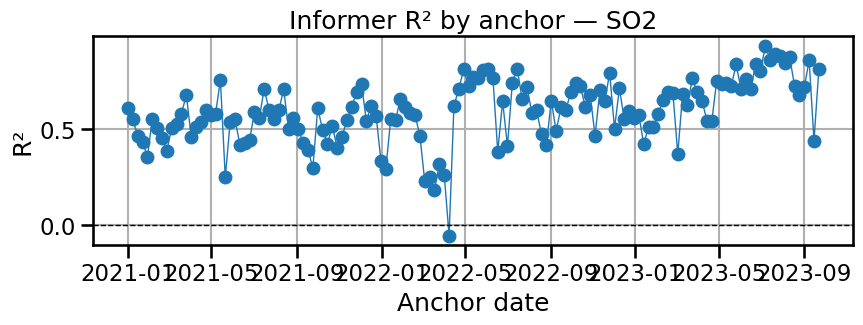

In [ ]:
# Rolling evaluation across the full test horizon (weekly anchors)
def rolling_eval_nf(nf_model: NeuralForecast,
                    full_df: pd.DataFrame,
                    test_start: pd.Timestamp,
                    test_end: pd.Timestamp,
                    step_days: int = 7) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Weekly anchors from test_start..test_end. Returns (per-anchor table, summary)."""
    anchors = pd.date_range(
        test_start,
        test_end - pd.Timedelta(days=CFG.PRED_WINDOW),
        freq=f"{step_days}D"
    )
    rows = []
    for a in anchors:
        # History up to anchor produces next H predictions
        hist = full_df[full_df["ds"] <= a].copy()
        if hist.empty:
            continue

        fcst = nf_model.predict(df=hist)
        pred_col = [c for c in fcst.columns if c not in ("unique_id", "ds")][0]

        # Restrict to the immediate H-day window (a, a+H]
        fcst_win = fcst[(fcst["ds"] > a) & (fcst["ds"] <= a + pd.Timedelta(days=CFG.PRED_WINDOW))]
        truth = full_df[(full_df["ds"] > a) & (full_df["ds"] <= a + pd.Timedelta(days=CFG.PRED_WINDOW))]

        ev = (
            truth.merge(fcst_win, on=["unique_id", "ds"], how="inner")
                 .rename(columns={pred_col: "y_pred"})
        )
        if ev.empty:
            continue
        ev["pollutant"] = ev["unique_id"].str.extract(r"_(o3|no2|so2|co)$")[0].str.upper()

        for pol, grp in ev.groupby("pollutant"):
            y, yhat = grp["y"].to_numpy(), grp["y_pred"].to_numpy()
            s = PPB_SCALE[pol]
            y_ppb, yhat_ppb = y * s, yhat * s

            rows.append({
                "anchor": a.date().isoformat(),
                "pollutant": pol,
                "R2": r2_score(y, yhat),
                "SMAPE_%": smape(y_ppb, yhat_ppb),
                "MSE_ppb2": float(np.mean((y_ppb - yhat_ppb) ** 2)),
                "N": int(len(grp)),
            })

    roll_tbl = pd.DataFrame(rows)
    if roll_tbl.empty:
        return roll_tbl, roll_tbl

    roll_summary = (
        roll_tbl.groupby("pollutant", as_index=False)
                .agg({
                    "R2": "mean",
                    "SMAPE_%": "mean",
                    "MSE_ppb2": "mean",
                    "N": "sum",
                })
                .sort_values("pollutant")
                .reset_index(drop=True)
    )
    return roll_tbl, roll_summary


# Run rolling eval over the full test window
full_df = df_nf.copy()
test_start = (VAL_END + pd.Timedelta(days=1))
test_end = full_df["ds"].max()

t0 = time.perf_counter()
roll_tbl, roll_summary = rolling_eval_nf(nf, full_df, test_start, test_end, CFG.ROLL_STEP_DAYS)
elapsed = time.perf_counter() - t0

print(f"Anchors: {roll_tbl['anchor'].nunique() if not roll_tbl.empty else 0} | time={elapsed:.2f}s")
display(roll_summary.round(3))

# Save artifacts
roll_tbl.to_csv(OUT_DIR / "rolling_eval_by_anchor.csv", index=False)
roll_summary.to_csv(OUT_DIR / "rolling_eval_summary.csv", index=False)

# plots: R^2 by anchor for each pollutant
if not roll_tbl.empty:
    for pol in sorted(roll_tbl["pollutant"].unique()):
        g = roll_tbl[roll_tbl["pollutant"] == pol].copy()
        # sort by anchor date for cleanliness
        g["anchor_dt"] = pd.to_datetime(g["anchor"])
        g = g.sort_values("anchor_dt")

        plt.figure(figsize=(9, 3.6))
        plt.plot(g["anchor_dt"], g["R2"], marker="o", linewidth=1)
        plt.title(f"Informer R^2 by anchor — {pol}")
        plt.axhline(0.0, color="k", linestyle="--", linewidth=1)
        plt.ylabel("R^2"); plt.xlabel("Anchor date")
        plt.tight_layout()
        plt.show()


⚠️ Negative R² diagnostic (rolling anchors):


,pollutant,mean_R2,median_R2,neg_R2_count,total,neg_share_%
0,CO,0.502,0.547,4.0,143.0,2.797
1,NO2,0.259,0.363,23.0,143.0,16.084
2,O3,0.185,0.194,27.0,143.0,18.881
3,SO2,0.593,0.599,1.0,143.0,0.699


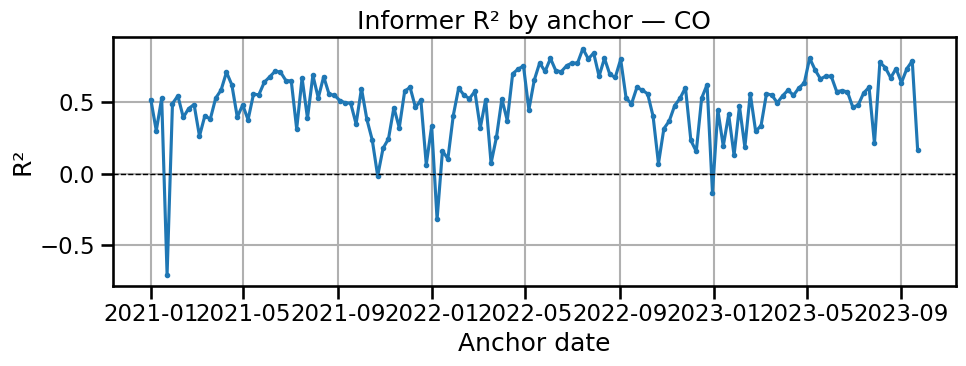

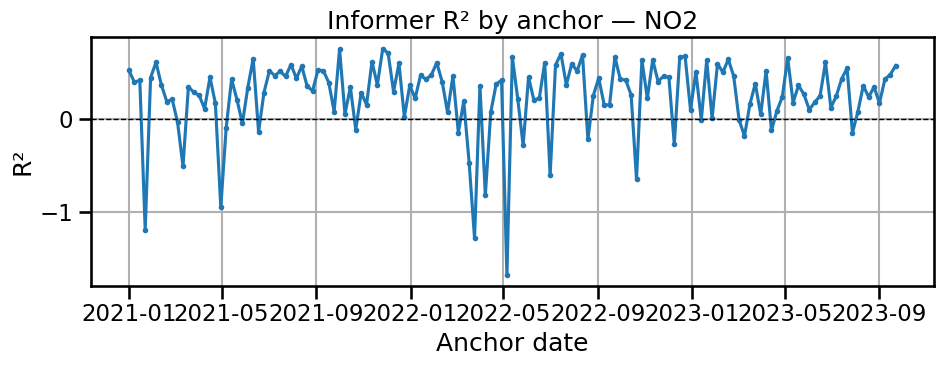

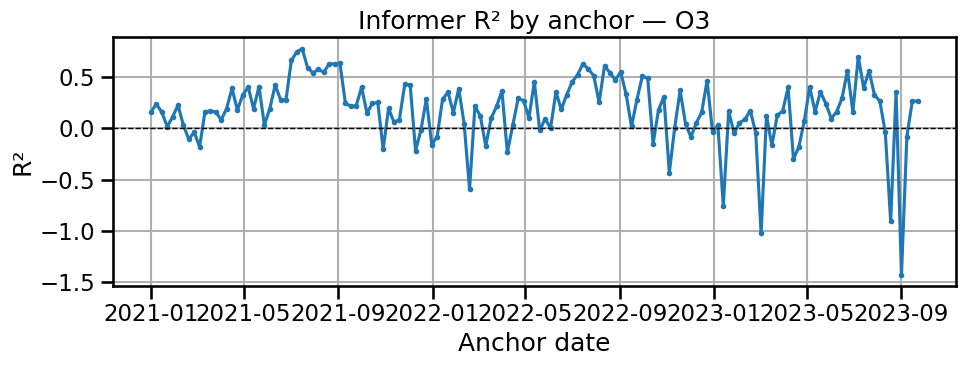

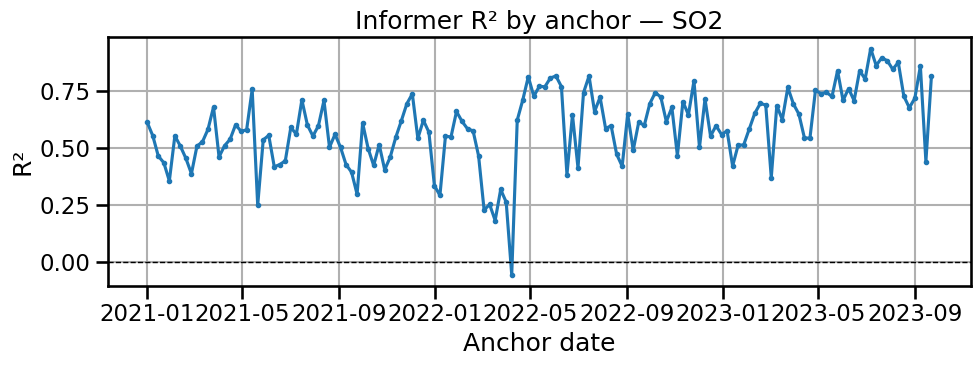

In [ ]:
# diagnose negative R^2 issue for O3 + line plots of R^2 by anchor

from pathlib import Path
MODEL_NAME = "Informer"
try:
    OUT_DIR
except NameError:
    OUT_DIR = Path("results")
(OUT_DIR / "figs").mkdir(parents=True, exist_ok=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def negative_r2_report(roll_tbl: pd.DataFrame) -> pd.DataFrame:
    """Share/summary of negative R^2 per pollutant over rolling anchors."""
    if roll_tbl is None or roll_tbl.empty:
        cols = ["pollutant", "mean_R2", "median_R2", "neg_R2_count", "total", "neg_share_%"]
        return pd.DataFrame(columns=cols)

    def summarize(g):
        vals = g["R2"].to_numpy()
        return pd.Series({
            "mean_R2": float(np.nanmean(vals)),
            "median_R2": float(np.nanmedian(vals)),
            "neg_R2_count": int((vals < 0).sum()),
            "total": int(len(vals)),
            "neg_share_%": float(100.0 * (vals < 0).sum() / max(1, len(vals))),
        })

    rep = (roll_tbl.groupby("pollutant")
                  .apply(summarize)
                  .reset_index())
    return rep

# build/save report
neg_report = negative_r2_report(roll_tbl)
print("Negative R^2 diagnostic (rolling anchors):")
display(neg_report.round(3))
neg_report.to_csv(OUT_DIR / "negative_r2_report_informer.csv", index=False)

#plot R^2 over anchors for each pollutant
if roll_tbl is not None and not roll_tbl.empty:
    for pol in sorted(roll_tbl["pollutant"].unique()):
        g = roll_tbl[roll_tbl["pollutant"] == pol].copy()
        g["anchor_dt"] = pd.to_datetime(g["anchor"])
        g = g.sort_values("anchor_dt")

        plt.figure(figsize=(10, 4))
        plt.plot(g["anchor_dt"], g["R2"], marker="o", ms=3)
        plt.axhline(0.0, ls="--", lw=1, color="k")
        plt.title(f"{MODEL_NAME} R² by anchor — {pol}")
        plt.ylabel("R²"); plt.xlabel("Anchor date")
        plt.tight_layout()
        plt.savefig(OUT_DIR / "figs" / f"{MODEL_NAME.lower()}_r2_by_anchor_{pol.lower()}.png", dpi=150)
        plt.show()


## 12. occlusion sensitivity

,R2,SMAPE_%,MSE_ppb2,N,model,split
0,0.472,19.757,17250.570,1016.0,Informer,Immediate
1,0.385,19.989,23592.274,128600.0,Informer,Rolling


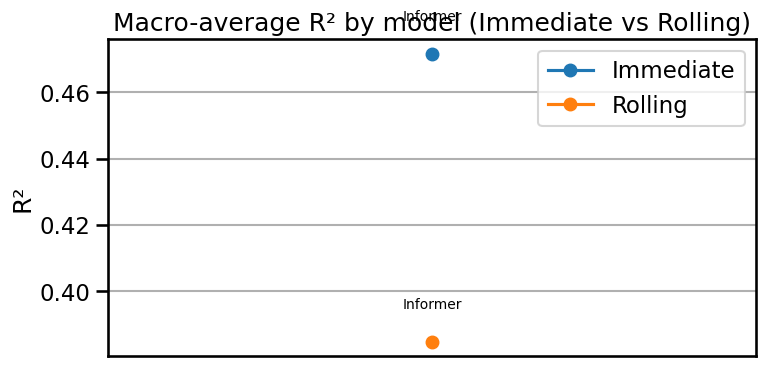

In [ ]:
# build a single comparison table (ready for slides/report)
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# helpers to macro-average across pollutants
def macro_avg_immediate(tbl: pd.DataFrame, model_name: str) -> dict:
    if tbl is None or tbl.empty:
        return {}
    d = tbl.agg({"R2": "mean", "SMAPE_%": "mean", "MSE_ppb2": "mean", "N": "sum"}).to_dict()
    d["model"] = model_name
    d["split"] = "Immediate"
    return d

def macro_avg_rolling(roll_summary: pd.DataFrame, model_name: str) -> dict:
    if roll_summary is None or roll_summary.empty:
        return {}
    d = roll_summary.agg({"R2": "mean", "SMAPE_%": "mean", "MSE_ppb2": "mean", "N": "sum"}).to_dict()
    d["model"] = model_name
    d["split"] = "Rolling"
    return d

compare_rows = []
# Informer
compare_rows.append(macro_avg_immediate(immediate_tbl, MODEL_NAME))
compare_rows.append(macro_avg_rolling(roll_summary, MODEL_NAME))

#method to add other models if we decided to aggregate everything in one notebook
def try_add_model(tag: str, immediate_csv: Path, rolling_csv: Path):
    if immediate_csv.exists():
        t = pd.read_csv(immediate_csv)
        d = t.agg({"R2": "mean", "SMAPE_%": "mean", "MSE_ppb2": "mean", "N": "sum"}).to_dict()
        d["model"] = tag; d["split"] = "Immediate"; compare_rows.append(d)
    if rolling_csv.exists():
        t = pd.read_csv(rolling_csv)
        d = t.agg({"R2": "mean", "SMAPE_%": "mean", "MSE_ppb2": "mean", "N": "sum"}).to_dict()
        d["model"] = tag; d["split"] = "Rolling"; compare_rows.append(d)
try_add_model("TFT",
              OUT_DIR / "metrics_immediate_tft.csv",
              OUT_DIR / "rolling_eval_summary_tft.csv")
try_add_model("LSTM",
              OUT_DIR / "metrics_immediate_lstm.csv",
              OUT_DIR / "rolling_eval_summary_lstm.csv")

compare_df = pd.DataFrame([r for r in compare_rows if r])
display(compare_df.round(3))
compare_df.to_csv(OUT_DIR / "model_comparison.csv", index=False)

# macro R^2 comparison (Immediate vs Rolling)
if not compare_df.empty:
    plt.figure(figsize=(8, 4))
    for split, g in compare_df.groupby("split"):
        xs = np.arange(len(g))
        plt.plot(xs, g["R2"], marker="o", label=split)
        for i, name in enumerate(g["model"]):
            plt.text(xs[i], g["R2"].iloc[i] + 0.01, name, ha="center", fontsize=10)
    plt.title("Macro-average R^2 by model (Immediate vs Rolling)")
    plt.ylabel("R^2"); plt.xticks([]); plt.legend()
    plt.tight_layout(); plt.show()
